Advanced lane finding pipeline
===



In [1]:
import numpy as np
import cv2
import glob
import pickle
from moviepy.editor import VideoFileClip
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
def compute_camera_calibration_matrix(save_images=0):
    '''Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
    '''
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            if save_images:
                # Draw and display the corners
                cv2.drawChessboardCorners(img, (9,6), corners, ret)
                cv2.imwrite("output_images/corners_found_{}".format(fname.split("/")[-1]), img)
    return (objpoints, imgpoints)


In [3]:
def undistort_camera_image(objpoints, imgpoints, img, fname='', save_images=0):
    '''Apply a distortion correction to raw images.
    '''
    # Test undistortion on an image
    img_size = (img.shape[1], img.shape[0])
    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    if save_images:
        write_name = 'output_images/undist_'+fname
        cv2.imwrite(write_name, img)

    return dst


In [4]:
def region_of_interest(img, vertices, fname='', save_images=0):
    """
    Applies an image mask.
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    if save_images:
        plt.imsave("output_images/masked_cmb_{}".format(fname.split("/")[-1]), masked_image)
    return masked_image

In [5]:
def generate_threshold_binary_image(img, s_thresh=(170, 255), sx_thresh=(20, 100), fname='', save_images=0): 
    '''Use color transforms, gradients, etc., to create a thresholded binary image.
    '''
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    if save_images:
        cv2.imwrite("output_images/cb_{}".format(fname.split("/")[-1]), color_binary*255)
        cv2.imwrite("output_images/cmb_{}".format(fname.split("/")[-1]), combined_binary*255)
        cv2.imwrite("output_images/sb_{}".format(fname.split("/")[-1]), s_binary*255)
        cv2.imwrite("output_images/sxb_{}".format(fname.split("/")[-1]), sxbinary*255)
    

    return (color_binary, combined_binary, s_binary, sxbinary)


In [6]:
def get_warp_matrix(img, save_images=0):
    
    img_size = (img.shape[1], img.shape[0])

    src = np.float32(
    [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
    [((img_size[0] / 6) - 10), img_size[1]],
    [(img_size[0] * 5 / 6) + 60, img_size[1]],
    [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])

    dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])

    #Compute perspective warp matrix
    M = cv2.getPerspectiveTransform(src, dst)

    #Compute the inverse perspective transform
    Minv = cv2.getPerspectiveTransform(dst, src)
    if save_images:
        #cv2.line(img, src[0], src[1],"red")
        print(src)
        cv2.polylines(img, np.int32([src]), True, (0,0,255), thickness=1, lineType=8, shift=0)
        cv2.imwrite("output_images/perspective_original.jpg", img)
        warped=cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
        cv2.imwrite("output_images/perspective_warped.jpg", warped)

    return (M, Minv)

In [7]:
def apply_perspective_transform(img, warp_matrix, fname='', save_images=0):
    '''Apply a perspective transform to rectify binary image ("birds-eye view").
    '''    
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, warp_matrix, img_size, flags=cv2.INTER_LINEAR)
    if save_images:
        plt.imsave("output_images/warped_{}".format(fname.split("/")[-1]), warped)    
    return warped

In [8]:
#Detect lane pixels and fit to find the lane boundary.
def detect_lanes_from_scratch(binary_warped, fname='', save_images=0):
    print("Brute force")
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 10
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    #determine curvature
    left_curverad, right_curverad=determine_curvature (ploty, leftx, lefty, rightx, righty)
    
    if save_images:
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 255, 0]
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        plt.imshow(out_img)
        cv2.imwrite("output_images/detect_lane_{}".format(fname.split("/")[-1]), out_img)
    return (ploty, left_curverad, right_curverad, left_fit, right_fit)

In [9]:
def detect_lanes_using_previous_lane_values(binary_warped, est_left_fit, est_right_fit, fname='', save_images=0):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!

    if est_left_fit is None or est_right_fit is None:
        return detect_lanes_from_scratch(binary_warped, fname=fname, save_images=save_images)

    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100

    est_nonzerox_upper = est_left_fit[0]*(nonzeroy**2) + est_left_fit[1]*nonzeroy + est_left_fit[2] + margin
    est_nonzerox_lower = est_left_fit[0]*(nonzeroy**2) + est_left_fit[1]*nonzeroy + est_left_fit[2] - margin

   

    left_lane_inds = ((nonzerox >= (est_left_fit[0]*(nonzeroy**2) + est_left_fit[1]*nonzeroy + est_left_fit[2]- margin)) 
                    & (nonzerox < (est_left_fit[0]*(nonzeroy**2) + est_left_fit[1]*nonzeroy + est_left_fit[2] + margin))).nonzero()[0] 

    right_lane_inds = ((nonzerox >= (est_right_fit[0]*(nonzeroy**2) + est_right_fit[1]*nonzeroy + est_right_fit[2] - margin)) 
                    & (nonzerox < (est_right_fit[0]*(nonzeroy**2) + est_right_fit[1]*nonzeroy + est_right_fit[2] + margin))).nonzero()[0]  

    

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]


    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)



    delta_left_fit = np.sqrt((left_fit-est_left_fit)**2)
    delta_right_fit = np.sqrt((right_fit-est_right_fit)**2)

    if delta_left_fit[0] > 0.0005 or delta_right_fit[0] > 0.0005:
        return detect_lanes_from_scratch(binary_warped, fname=fname, save_images=save_images)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    
    
    left_curverad, right_curverad=determine_curvature (ploty, leftx, lefty, rightx, righty)

    if save_images:
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        cv2.imwrite("output_images/detect_lane_{}".format(fname.split("/")[-1]), out_img)
    return (ploty, left_curverad, right_curverad, left_fit, right_fit)


In [10]:
#Determine the curvature of the lane and vehicle position with respect to center.
def determine_curvature (ploty, leftx, lefty, rightx, righty):
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    return (left_curverad, right_curverad)


In [11]:
#Warp the detected lane boundaries back onto the original image.
def warp_onto_original(undist, warped, Minv, ploty, left_fit, right_fit, fname='', save_images=0):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
       
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])

    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), False, (0,0,255), thickness=20)
    cv2.polylines(color_warp, np.int32([pts_right]), False, (0,0,255), thickness=20)


    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    if save_images:
        cv2.imwrite("output_images/final_{}".format(fname.split("/")[-1]), result)
    return result

In [12]:
def test_image_pipeline(warp_matrices, region_of_interest_vertices, save_images):
    
    images = glob.glob('test_images/test*.jpg')

    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        undist = undistort_camera_image(objpoints, imgpoints, img, fname=fname, save_images=save_images)
        cb, cmb, sb, sxb = generate_threshold_binary_image(undist, s_thresh=(170, 255), sx_thresh=(20, 100), fname=fname, save_images=save_images)
        masked_binary = region_of_interest(cmb,region_of_interest_vertices, fname=fname, save_images=save_images)
        warped = apply_perspective_transform(masked_binary, warp_matrices[0], fname=fname, save_images=save_images)
        ploty, left_curverad, right_curverad, left_fit, right_fit = detect_lanes_from_scratch(warped, fname=fname, save_images=save_images)
        print(left_curverad, 'm', right_curverad, 'm')
        warp_onto_original(undist, warped, warp_matrices[1], ploty, left_fit, right_fit, fname=fname, save_images=save_images)


In [13]:
def process_frame(image):
    global save_images, frm_cnt, objpoints, imgpoints, warp_matrix, inv_warp_matrix, region_of_interest_vertices, \
           prev_left_fit, prev_right_fit
    frm_cnt += 1
    fname = "output_images/frame_{}.jpg".format(frm_cnt)
    undist = undistort_camera_image(objpoints, imgpoints, image, fname=fname, save_images=save_images)
    cb, cmb, sb, sxb = generate_threshold_binary_image(undist, s_thresh=(170, 255), sx_thresh=(20, 100), fname=fname, save_images=save_images)
    masked_binary = region_of_interest(cmb,region_of_interest_vertices, fname=fname, save_images=save_images)
    binary_warped = apply_perspective_transform(masked_binary, warp_matrix, fname=fname, save_images=save_images)
    ploty, left_curverad, right_curverad, left_fit, right_fit = detect_lanes_using_previous_lane_values(binary_warped, prev_left_fit, prev_right_fit, fname='', save_images=0)
    prev_left_fit, prev_right_fit = left_fit, right_fit

    #print(left_curverad, 'm', right_curverad, 'm')
    result=warp_onto_original(undist, binary_warped, inv_warp_matrix, ploty, left_fit, right_fit, fname=fname, save_images=save_images)
    return result

[[  585.           460.        ]
 [  203.33332825   720.        ]
 [ 1126.66662598   720.        ]
 [  695.           460.        ]]
Brute force
894.108001002 m 37148.9979979 m
Brute force
739.190825021 m 4557.42822301 m
Brute force
1213.62853994 m 656.406812562 m
Brute force
723.055485203 m 732.336538675 m
Brute force
1527.24626046 m 54.86273598 m
Brute force
1209.4788146 m 1089.94371582 m
Brute force
[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4


 42%|████▏     | 534/1261 [11:00<15:11,  1.25s/it]

Brute force


 78%|███████▊  | 984/1261 [20:19<05:46,  1.25s/it]

Brute force


 78%|███████▊  | 985/1261 [20:20<05:47,  1.26s/it]

Brute force


 82%|████████▏ | 1038/1261 [21:27<04:47,  1.29s/it]

Brute force


 82%|████████▏ | 1039/1261 [21:29<04:47,  1.29s/it]

Brute force


 82%|████████▏ | 1040/1261 [21:30<04:46,  1.30s/it]

Brute force


 83%|████████▎ | 1042/1261 [21:32<04:43,  1.29s/it]

Brute force


 83%|████████▎ | 1043/1261 [21:34<04:41,  1.29s/it]

Brute force


100%|█████████▉| 1260/1261 [26:05<00:01,  1.25s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 



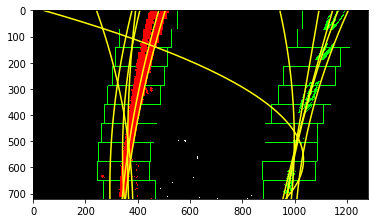

In [14]:
if __name__=="__main__":
    save_images=1
    objpoints, imgpoints = compute_camera_calibration_matrix(save_images=save_images)
    warp_matrix, inv_warp_matrix = get_warp_matrix(cv2.imread("test_images/straight_lines2.jpg"), save_images=save_images)
    region_of_interest_vertices = np.array([[(120,720), (600,420), (680, 420), (1200,720)]], dtype=np.int32)
    test_image_pipeline((warp_matrix, inv_warp_matrix), region_of_interest_vertices, save_images)
    
    frm_cnt=0
    prev_left_fit = None
    prev_right_fit = None
    clip1 = VideoFileClip("project_video.mp4")
    clip = clip1.fl_image(process_frame) #NOTE: this function expects color images!!
    clip.write_videofile("output.mp4", audio=False)
    